# **Relazione finale**

**Gruppo**: BigCovid

**Componenti del gruppo**: Alessio Verdolini, Federico Gaglio

# *Indice*

1. **Analisi del dataset**

2. **Commons**

3. **Primo job**

  3.1 *MapReduce*
  
  3.2 *Hive*

  3.3 *Spark*

  3.4 *Risultati*

  3.5 *Grafici*
  

4. **Secondo job**

  4.1 *MapReduce*

  4.2 *Hive*

  4.3 *Spark*

  4.4 *Risultati*

  4.5 *Grafici*
  
  
5. **Terzo job**

  5.1 *MapReduce*

  5.2 *Hive*

  5.3 *Spark*

  5.4 *Risultati*

  5.5 *Grafici*

# 1. Analisi del dataset

# 2. Commons

### 2.1 Grafici


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import csv

CSV_PATH='time-execute/'


def draw_plot(job_number):
    LOCAL = CSV_PATH+'local_'+str(job_number)+'.csv'
    CLUSTER = CSV_PATH+'cluster_'+str(job_number)+'.csv'
    
    dataset={}
    data_local = {}
    data_cluster = {}
    
    with open(LOCAL,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_local[job]=[float(x) for x in times]
        dataset[0] = {
            'name': "Locale",
            'time': data_local
        }
    
    with open(CLUSTER,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_cluster[job]=[float(x) for x in times]
        dataset[1] = {
            'name': "Cluster",
            'time': data_cluster
        }
        
    plot, axs = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(0,2):
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['1'], color='tab:blue', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['2'], color='tab:orange', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['3'], color='tab:green', marker='o')
        
        axs[i].set_title(dataset[i]['name'])
        axs[i].set_xlabel('Dimensione (MB)')
        axs[i].set_ylabel('Tempo (m)')
        axs[i].grid(alpha=0.4)
        axs[i].legend(['MapReduce', 'Hive', 'Spark'])

### 2.2 MapReduce

#### 2.2.1 Oggetti MapReduce

**AverageObject**

Oggetto utilizzato per facilitare la lettura del codice astraendo la logica del calcolo della media dal resto dell'algoritmo.

L'oggetto offre due meotodi:

1. **add**: aggiorna lo stato della memoria.
2. **avg**: esegue la media effettiva.

In [0]:
class AverageObject:

    def __init__(self, value=0.0):
        self.value = value
        self.count = 1 if value else 0

    def add(self, value):
        self.value += value
        self.count += 1
        
    def avg(self):
        return self.value / self.count


**Record**

Oggetto utilizzato per memorizzare, utilizzando tre differenti istanze del suddetto AverageObject, i seguenti valori:

1. **Volume medio**

2. **Variazione percentuale media**

3. **Variazione media giornaliera**

Utilizzando i tre metodi presenti all'interno dell'oggetto è possibile modificare i rispettivi valori di interesse. 

*Esempio:*

```json
Record = {
    'avg_year_volume': AverageObject,
    'avg_year_change_company': AverageObject,
    'avg_daily_price': AverageObject,
}
```

In [0]:
class Record:

    def __init__(self):
        self.avg_year_volume = AverageObject()
        self.avg_year_change_company = AverageObject()
        self.avg_daily_price = AverageObject()

    def add_volume(self, volume):
        self.avg_year_volume.add(volume)

    def add_year_change(self, year_change):
        self.avg_year_change_company.add(year_change)
        
    def add_daily_price(self, daily_price):
        self.avg_daily_price.add(daily_price)

**Sector**

Oggetto che memorizza il nome del settore e, per ogni anno, i tre parametri richiesti dall'esercizio.

Per la memorizzazione dei parametri utilizziamo un dizionario con chiave **anno** e valore un oggetto **Record**.

*Esempio:*

```json
Sector = {
    'name': 'NomeSettore',
    'year_2_record': {
            '2008': Record,
            '2009': Record,
            '2010': Record
    }
}
```

In [0]:
class Sector:

    def __init__(self, name):
        self.name = name
        self.year_2_record = {}
        
    def update(self, year, volume, year_change, daily_price):
        if not (year in self.year_2_record):
            self.year_2_record[year] = Record()
        self.year_2_record[year].add_volume(volume)
        self.year_2_record[year].add_year_change(year_change)
        self.year_2_record[year].add_daily_price(daily_price)

**Company**

Oggetto utilizzato per memorizzare il nome dell'azienda e le rispettive variazioni di quotazione annuali degli ultimi tre anni.


*Esempio:*

```json
Company = {
    'name': 'NomeAzienda',
    'change_year': {
            '2016': +10%,
            '2017': -1%,
            '2018': +3%
    }
}
```

In [0]:
class Company:
  
    def __init__(self, name):
        self.name = name
        self.change_year = {}

#### 2.2.2 Estrazione da file esterni

Questi snippets vengono utilizzati all'interno dei mapper per l'estrazione delle informazioni riguardanti rispettivamente settore e nome delle aziende, associando mediante un dizionario ai rispettivi ticker. 

Questa operazione permette successivamente di effettuare un merge dei due dataset.


*Esempio:*

```json
ticker_2_Sector = {
    'APP': 'Settore 1',
    'MIC': 'Settore 2',
    'FAC': 'Settore 3',
}
```

```json
ticker_2_Name = {
    'APP': 'Apple Inc.',
    'MIC': 'Microsoft Inc.',
    'FAC': 'Facebook Inc.',
}
```

In [0]:
import csv

STOCKS_INFO_FILE = 'dataset/historical_stocks.csv'

ticker_2_Sector = {}

with open(STOCKS_INFO_FILE) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    firstLine = True

    for row in csv_reader:
        if not firstLine:
            ticker, _, _, sector, _ = row
            if sector != 'N/A':
                ticker_2_Sector[ticker] = sector
        else:
            firstLine = False
            
ticker_2_name = {}

with open(STOCKS_INFO_FILE) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    firstLine = True

    for row in csv_reader:
        if not firstLine:
            ticker, _, name, _, _ = row
            if name != 'N/A':
                ticker_2_name[ticker] = name
        else:
            firstLine = False

### 2.3 Hive

#### 2.3.1 Creazione delle tabelle partendo da file csv

La prima query viene utilizzata per creare la tabella `historical_stock_prices` che contiene tutti i campi del file csv originale effettuando appositi cast in funzione del tipo del campo.

Questa tabella sarà utile per estrarre i dati relativi a:

<br>


|Colonna|Descrizione|
|:-------:|:-----:|
|ticker|Il ticker di riferimento|
|close|La quotazione del ticker a fine giornata|
|volume|Il volume giornaliero sul singolo ticker|
|data|La data di registrazione del record (data)|

<br>

L'espressione `TBLPROPERTIES("skip.header.line.count"="1")` viene utilizzata per escludere dall'elaborazione la prima riga del file contenente l'intestazione.


```sql
CREATE TABLE IF NOT EXISTS historical_stock_prices (
	ticker STRING, 
	open STRING, 
	close double, 
	adj_close STRING, 
	low STRING, 
	high STRING, 
	volume int, 
	data STRING)

ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
TBLPROPERTIES("skip.header.line.count"="1");

LOAD DATA LOCAL INPATH '<path>/<file>.csv' 
OVERWRITE INTO TABLE historical_stock_prices;
```


La seconda query viene utilizzata per creare la tabella `historical_stock` che contiene tutti i campi del file csv originale effettuando appositi cast in funzione del tipo del campo. 

Questa tabella sarà utile per estrarre i dati relativi a:

<br>


|Colonna|Descrizione|
|:-------:|:-----:|
|ticker|Il ticker di riferimento|
|name|Il nome dell'azienda proprietaria del ticker|
|sector|Il settore di competenza dell'azienda|

<br>

```sql
CREATE TABLE IF NOT EXISTS historical_stock (
	ticker STRING, 
	exchanges STRING, 
	name STRING, 
	sector STRING, 
	industry STRING)
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
TBLPROPERTIES("skip.header.line.count"="1");

LOAD DATA LOCAL INPATH '<path>/<file>.csv' 
OVERWRITE INTO TABLE historical_stock;
```

### 3.3 Spark

#### 2.3.1 Creazione delgli RDD partendo da file csv

```python
conf = SparkConf().setMaster("local[*]").setAppName("Job2")
sc = SparkContext(conf=conf)
```

```python
input_file = sc.textFile(
    "file:///<path>/<file.csv>") \
    .map(lambda line: line.split(","))

input_file = input_file \
    .filter(lambda line: line[0] != "ticker") \
    .filter(lambda line: "2008" <= line[7][0:4] <= "2018")
```

```python
input_file_2 = sc.textFile(
    "file:///<path>/<file.csv>") \
    .map(lambda line: line.split(","))

input_file_2 = input_file_2 \
    .filter(lambda line: line[0] != "ticker") \
    .filter(lambda line: line[3] != "N/A") \
```

# 3. Primo job

### 3.1 Map Reduce

Un job che sia in grado di generare le statistiche di ciascuna azione tra il 2008 e il 2018 indicando, per ogni azione: (a) il simbolo, (b) la variazione della quotazione (differenza percentuale arrotondata tra i prezzi di chiusura iniziale e finale dell’intervallo temporale), (c) il prezzo minimo, (e) quello massimo e (f) il volume medio nell’intervallo, ordinando l’elenco in ordine decrescente di variazione della quotazione.

**Config**

La seguente configurazione inserita nello script di avvio del job permette di specificare:

- ***stream.map.output.field.separator='\t'***: ogni campo dell'output del mapper è separato da un 'tab'
- ***stream.num.map.output.key.fields=2***: i primi due elementi dell'output del mapper costiruiscono la chiave utilizzata per l'ordinamento e il partizionamento dei risultati.
- ***mapreduce.job.reduces=1***: indica che sarà presente un solo task di reduce

```bash
-D stream.map.output.field.separator='\t' \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.job.reduces=1 \
```

**Mapper**


In fase di mapping estraiamo da ciascun record i campi *ticker*, *date*, *close*, *volume*.

```python
class Mapper:

  for line in file.csv

    extract ticker, close, volume, date from file.csv
    
    if year in (2008, 2018)
      send to reducer ticker, data, close, volume
```

**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw.

```python
class Reducer:
  
  define AvgVolume object

  for line in mapper output

    extract ticker, year, close, volume

    percentage_change = ((last_close_price - first_close_price) / first_close_price) * 100
    min_price = min(close)
    max_price = max(close)
    avg_volume = avg(volume)
    
    sorting values based on percentage_change key
```



### 3.2 Hive

**Implementazione Hive**

---

```
ticker_min_max_avg(ticker, min_price, max_price, avg_volume) 
```

>**min_price:** *Valore minimo di chiusura*
<br>
>**max_price:** *Valore massimo di chiusura*
<br>
>**avg_volume:** *Volume medio nell'intervallo*

<br>

```
ticker_first_last_data(ticker, first_data, last_data) 
```

>**first_data:** *La prima data in cui è stato quotato il ticker*
<br>
>**last_data:** *L'ultima data in cui è stato quotato il ticker*

<br>

```
ticker_close_first_data(ticker, data, first_price) 
```
>**first_price**: *Valore iniziale di chiusura*

<br>

```
ticker_close_last_data(ticker, data, last_price) 
```
>**last_price**: *Valore finale di chiusura*

<br>

```
ticker_percentage(ticker, inc_per) 
```
>**inc_per**: *Variazione di quotazione (((last_price-first_price)/first_price)x100)*


```sql
CREATE TABLE IF NOT EXISTS ticker_min_max_avg AS
SELECT ticker, min(close) AS min_price, max(close) AS max_price, avg(volume) AS avg_volume
FROM historical_stock_prices
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_first_last_data AS
SELECT ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data
FROM historical_stock_prices
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS
SELECT h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data AS t
JOIN historical_stock_prices AS h
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS
SELECT h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data AS t
JOIN historical_stock_prices AS h
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS
SELECT fc.ticker, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker;

CREATE TABLE IF NOT EXISTS result_job_1 AS 
SELECT t.ticker, p.inc_per, t.min_price, t.max_price, t.avg_volume
FROM ticker_min_max_avg AS t
JOIN ticker_percentage AS p
ON t.ticker=p.ticker 
ORDER BY p.inc_per DESC limit 10;
```

### 3.3 Spark

**Implementazione Spark**


```python

main_table: (ticker, open, close, adj_close, lowThe, highThe, volume, date)

main_table.persist(StorageLevel.MEMORY_AND_DISK)

#(ticker, min_close)
min_ticker_close = main_table \
    .map(line -> (ticker, close)) \
    .reduceByKey(min(close))

#(ticker, max_close)
max_ticker_close = main_table \
    .map(line -> (ticker, close)) \
    .reduceByKey(max(close))

#(ticker, avg_volume)
avg_ticker_volume = main_table \
    .map(line -> (ticker, (volume, 1))) \
    .reduceByKey((sum_volume), count) \
    .map(line -> (ticker, (sum_volume / count)))

# (ticker, (close, first_data))
first_data_close = main_table \
    .map(line -> (ticker, (close, date))) \
    .reduceByKey(min(date))

# (ticker, (close, last_data))
last_data_close = main_table \
    .map(line -> (ticker, (close, date))) \
    .reduceByKey(max(date))

# (ticker, ((close, first_data), (close, last_data)))
join_inc_per = first_data_close.join(last_data_close)

# (ticker, inc_per)
inc_per = join_inc_per \
    .map(line -> (ticker, (((last_close - first_close) / first_close) * 100)))

# (ticker, (((min, max), avg), inc_prc))
result = min_ticker_low \
    .join(max_ticker_high) \
    .join(avg_ticker_volume) \
    .join(inc_per) \
    .sortBy(ticker) \
    .map(line -> {"ticker": ticker,
                  "min_price": min_price,
                  "max_price": max_price,
                  "average_volume": average_volume,
                  "increase_percent": increase_percent})

result.coalesce(1).saveAsTextFile("file:///<path>/<file>")
```









### 3.4 Risultati

Si mostra ora l'output restituito per il primo job:

<br>


Ticker|Variazione percentuale|Min|Max|Volume medio
:-------:|:-----:|:---:|:-------:|:-----:|
CTZ|120300.00231%|0.00499999988824|26.7299995422|52052.2675097
SAB|110428.769954%|1.39849996567|318800.0|1695843.19004
WP|62125.8040042%|0.0500000007451|96.4499969482|1521133.15375
HMI|17899.3373828%|0.00860999990255|22.9099998474|335224.160078
PJT|16837.1427968%|0.0450000017881|10947.2001953|87650.1165182
MRNS|13852.3698384%|0.0415700003505|118.599998474|431270.206566
BHF|13245.1608431%|0.0209999997169|70.0|888734.91092
SLGL|12838.77616%|0.0010000000475|13.6400003433|318063.080844
BSM|11192.5669223%|0.0466700010002|19.5499992371|10629280.2865
ERI|10955.5558484%|0.00499999988824|49.75|405980.691818
NFLX|9432.22008418%|2.56285715103|418.970001221|20664584.2596
VER|9111.76451923%|0.00499999988824|17.8199996948|5167510.82112
TWLO|5136.12942961%|0.000199999994948|81.1600036621|2147141.03567
CTSO|5004.16678075%|0.0299999993294|14.9899997711|481264.641317
MB|4502.67351789%|0.369859993458|44.5999984741|406713.521043

<br>

### 3.5 Grafici

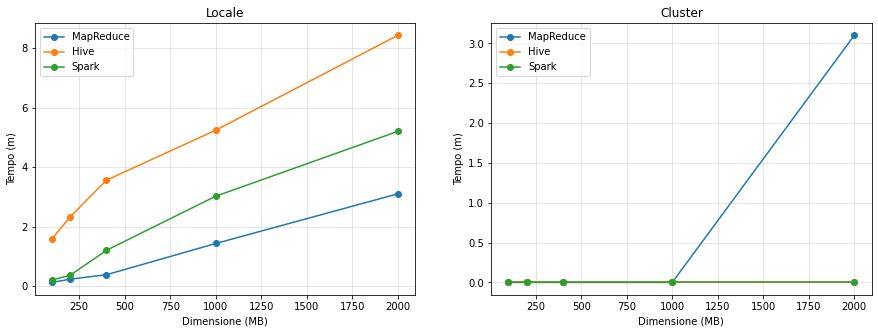

In [6]:
draw_plot(1)

# 4. Secondo job

### 4.1 Map Reduce

Un job che sia in grado di generare, per ciascun settore, il relativo “trend” nel periodo 2008-2018 ovvero un elenco contenete, per ciascun anno nell’intervallo: (a) il volume annuale1 medio delle azioni del settore, (b) la variazione annuale2 media delle aziende del settore e (c) la quotazione giornaliera media delle aziende del settore.

**Config**

La seguente configurazione inserita nello script di avvio del job permette di specificare:

- ***stream.map.output.field.separator='\t'***: ogni campo dell'output del mapper è separato da un 'tab'
- ***stream.num.map.output.key.fields=3***: i primi tre elementi dell'output del mapper costiruiscono la chiave utilizzata per l'ordinamento e il partizionamento dei risultati.
- ***mapreduce.job.reduces=1***: indica che sarà presente un solo task di reduce



```bash
-D stream.map.output.field.separator='\t' \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.job.reduces=1 \
```



**Mapper**

In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal file caricato su Hadoop estraiamo i campi *ticker*, *close*, *volume*, *date*, mentre dal file che leggiamo direttamente dal nostro IDE estraiamo i campi *ticker* e *sector*.
Le chiavi che vengono usate in questo secondo job sono 3: *sector*, *ticker* e *date*.


```python
class Mapper:

  extract ticker, sector from localFile

  for line in input
    extract ticker, close, volume, date

    if year in (2008,2018)
      send to reducer sector, ticker, date, close, volume
```



**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw.



```python
class Reducer:

  result = dict of objects Result

  for line in mapper output
    
    extract sector, ticker, year, close, volume
  
    if first_iteration:
          inizialize variables()
    else:

      if not (sector, ticker, year) changed:
        increase_temporary_variables()

      else:

        if sector changed:
          create new sector

        add_sector_to_result()
        restore_temporary_variables()

    update_local_variables()

  if current_sector:
    add_sector_to_result()
  
  print result
```



### 4.2 Hive

**Implementazione Hive**

---

```
ticker_data_volume(sector, ticker, anno, sum_volume) 
```

>**sum_volume**: *Volume totale di un ticker in un anno*

<br>

```
sector_data_avg_volume(sector, anno, avg_volume ) 
```

>**avg_volume**: *Volume annuale medio delle azioni del settore*

<br>

```
ticker_first_last_data_year(sector, ticker, first_data, last_data) 
```

>**first_data**: *La prima data in cui è stato quotato il ticker in un anno*
<br>
>**last_data**: *L'ultima data in cui è stato quotato il ticker in un anno*

<br>
 
```
ticker_close_first_data(sector, ticker, data, first_price) 
```

>**first_price**: *Primo valore di chiusura in un anno*

<br>
 
```
ticker_close_last_data(sector, ticker, data, last_price) 
```

>**last_price**: *Ultimo valore di chiusura in un anno*

<br>

```
ticker_percentage(sector, ticker, anno, inc_per) 
```

>**inc_per**: *Variazione della quotazione nell'anno(((last_price-first_price)/first_price)x100)*

<br>

```
sector_avg_percentage(sector, anno, avg_per) 
```

>**avg_per**: *La variazione annuale media delle aziende del settore in un anno*

<br>

```
ticker_avg_price(sector, ticker, anno, avg_ticker_price) 
```

>**avg_ticker_price**: *La quotazione giornaliera media del ticker in un anno*

<br>
 
```
sector_avg_price(sector, anno, avg_sector_price) 
```

>**avg_sector_price**: *La quotazione giornaliera media delle aziende del settore in un anno*


```sql
CREATE TABLE IF NOT EXISTS main_table AS 
SELECT hs.sector, hsp.ticker, hsp.data, hsp.close, hsp.volume 
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2008 AND YEAR(hsp.data)<=2018 
AND hs.sector!='N/A';

CREATE TABLE IF NOT EXISTS ticker_data_volume AS 
SELECT sector, ticker, YEAR(data) AS anno, SUM(volume) AS sum_volume 
FROM main_table 
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS sector_data_avg_volume AS 
SELECT sector, anno, AVG(sum_volume) AS avg_volume 
FROM ticker_data_volume 
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS ticker_first_last_data_year AS 
SELECT sector, ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data 
FROM main_table 
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS 
SELECT fc.sector, fc.ticker, YEAR(fc.data) as anno, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per 
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker AND YEAR(lc.data)=YEAR(fc.data);

CREATE TABLE IF NOT EXISTS sector_avg_percentage AS 
SELECT sector, anno, AVG(inc_per) AS avg_per
FROM ticker_percentage
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS ticker_avg_price AS
SELECT sector, ticker, YEAR(data) AS anno, AVG(close) AS avg_ticker_price
FROM main_table
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS sector_avg_price AS
SELECT sector, anno, AVG(avg_ticker_price) AS avg_sector_price
FROM ticker_avg_price
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS result_job_2 AS 
SELECT a.sector, a.anno, a.avg_volume, b.avg_per, c.avg_sector_price 
FROM sector_data_avg_volume AS a
JOIN sector_avg_percentage AS b
JOIN sector_avg_price AS c 
ON a.sector=b.sector AND b.sector=c.sector AND a.anno=b.anno AND b.anno=c.anno
ORDER BY sector, anno;

```

### 4.3 Spark

**Implementazione Spark**


```python
# (ticker, ((close, volume, date), sector))
main_table = input_file \
    .map(line -> (ticker, (close, volume, date))) \
    .join(input_file_2.map(line -> (ticker, (sector))))

# (ticker, close, volume, date, sector)
main_table = main_table \
    .map(line -> (ticker, close, volume, date, sector))

# persist RDD in memory
main_table.persist(StorageLevel.MEMORY_AND_DISK)

# ((sector, year), avg_volume)
avg_volume = main_table \
    .map(line -> ((sector, year), (volume, 1))) \
    .reduceByKey(sum_volume, count) \
    .map(line -> ((sector, year), sum_volume/count))

# ((sector, ticker, year), (first_date_close, close)))
first_data = main_table \
    .map(line -> ((sector, ticker, year)), (date, close))) \
    .reduceByKey(min(date))

# ((sector, ticker, year), (last_date_close, close)))
last_data = main_table \
    .map(line -> ((sector, ticker, year)), (date, close))) \
    .reduceByKey(max(date))

# ((sector, ticker, year), ((first_date_close, close), (last_date_close, close)))
year_change = first_data.join(last_data)

# ((sector, ticker, year), var)
year_change = year_change \
    .map(line -> ((sector, ticker, year), 
    ((last_date_close - first_date_close)/first_date_close)*100))

# ((sector, year), avg_var)
year_change = year_change \
    .map(line -> ((sector, year), (close, 1))) \
    .reduceByKey(sum_close, count) \
    .map(line -> ((sector, year), sum_close / count))

# ((sector, ticker, year), avg_close)
daily_price = main_table \
    .map(line -> ((sector, ticker, year), (close, 1))) \
    .reduceByKey(sum_close, count) \
    .map(line -> ((sector, ticker, year), sum_close / count))

# ((sector, year), avg_avg_close)
daily_price = main_table \
    .map(line -> ((sector, ticker, year), (avg_close, 1))) \
    .reduceByKey(avg_close, count) \
    .map(line -> ((sector, ticker, year), avg_close / count))

# ((sector, year), ((avg_volume, year_change), avg_avg_close))
result = avg_volume.join(year_change).join(daily_price)

# (sector, year, avg_volume, year_change, avg_avg_close)
result = result \
    .map(line -> (sector, year, avg_volume, year_change, avg_avg_close)

result.coalesce(1).saveAsTextFile("file:///<path>/<file>")
```










### 4.4 Risultati

Si mostra ora l'output restituito per il secondo job:

<br>

```json
{
    CONSUMER DURABLES {
        "2016": { 114494259.938, 21.0101353294, 36.0945546626},
        "2017": { 107339691.299, 112.438179391, 40.7140912909},
        "2018": { 82058317.4203, 18.8310904197, 42.567710353},
        "2008": { 189707640.363, -39.4536479674, 22.2723199275},
        "2009": { 175269648.158, 73.3650598171, 17.4845609756},
        "2010": { 137737200.243, 22.5322820912, 41.7208901012},
        "2011": { 142836151.667, -0.939463989497, 24.0781989471},
        "2012": { 120685957.807, 19.919298026, 23.0941351935},
        "2013": { 111316810.195, 46.8654469579, 69.871853462},
        "2014": { 107521042.843, 16.8480578465, 53.1592649849},
        "2015": { 98596714.2481, -1.98112751426, 37.4656460943}
    }

    TRANSPORTATION {
        "2016": { 258784869.029, 42.1387292082, 12401.0155205},
        "2017": { 233495747.84, 12.2084307132, 91.8670761748},
        "2018": { 140913962.5, -4.16276607725, 38.1655661574},
        "2008": { 453937649.333, -34.9735406028, 1780.34514679},
        "2009": { 423248363.158, 27.5861876887, 401.159294616},
        "2010": { 317762681.013, 20.0234073057, 157.780121063},
        "2011": { 296520680.247, -18.5469145159, 687.588274648},
        "2012": { 253087591.358, 8.89261314221, 595.033061445},
        "2013": { 238192173.256, 50.104813572, 506.378637507},
        "2014": { 258215538.71, 11.1744825672, 274.038437227},
        "2015": { 272514826.283, -22.681289206, 91.5300237925}
    }
}
```

<br>

### 4.5 Grafici

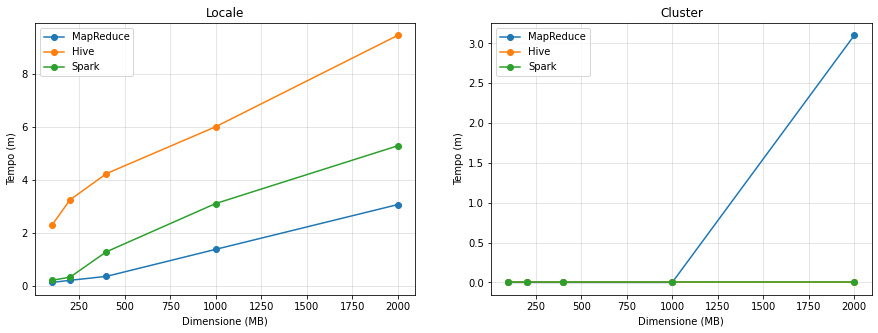

In [9]:
draw_plot(2)

# 5. Terzo job

### 5.1 Map Reduce

Un job in grado di generare gruppi di aziende le cui azioni hanno avuto lo stesso trend in termini di variazione annuale nell’ultimo triennio disponibile, indicando le aziende e il trend comune (es. {Apple, Intel, Amazon}: 2016:-1%, 2017:+3%, 2018:+5%).

**Config**

La seguente configurazione inserita nello script di avvio del job permette di specificare:


***Primo ciclo map-reduce***:
- ***stream.map.output.field.separator='\t'***: ogni campo dell'output del mapper è separato da un 'tab'
- ***stream.num.map.output.key.fields=2***: i primi due elementi dell'output del mapper costiruiscono la chiave utilizzata per l'ordinamento e il partizionamento dei risultati.
- ***mapreduce.job.reduces=1***: indica che sarà presente un solo task di reduce

<br>

***Secondo ciclo map-reduce***:
- ***stream.map.output.field.separator='\t'***: ogni campo dell'output del mapper è separato da un 'tab'
- ***stream.num.map.output.key.fields=3***: i primi tre elementi dell'output del mapper costiruiscono la chiave utilizzata per l'ordinamento e il partizionamento dei risultati.
- ***mapreduce.job.reduces=1***: indica che sarà presente un solo task di reduce




```bash
-D stream.map.output.field.separator='\t' \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.job.reduces=1 \
```

```bash
-D stream.map.output.field.separator='\t' \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.job.reduces=1 \
```

**Mapper 1**


In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal primo estraiamo i campi *ticker*, *close*, *date*, mentre dal secondo estraiamo i campi *ticker* e *name*.
Le chiavi che vengono usate in questo secondo job sono 2: *sector*, *date*.

```python
class Mapper:

  extract ticker, name from localFile

  for line in input
    extract ticker, close, date

    if year in (2016,2018)
      send to reducer1 ticker, date, close, name
```



**Reducer 1**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

```python
class Reducer1:

    extract ticker, date, close, name

    if first_iteration:
        initialize_variables()

    else:
        if current_ticker == ticker and current_year == year:
            last_close_ticker_year = close
        else:
            add_trend_to_company()

            if current_ticker != ticker:
                result.append(current_company)
                current_company = Company(name)

            initialize_variables(ticker, year, close)

```



**Mapper 2**

Questo secondo mapper l'unica cosa che va a fare è leggere l'output del primo reducer da Hadoop e lo va a passare al secondo reducer



```python
for line in input
  send line to reducer2 
```



**Reducer 2**

In fase di reducing, dopo aver estratto i valori passati dal mapper2, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

```python
class Reducer2:

    extract first_year, second_year, third_year, name

    if first_iteration:
        initialize_variables(first_year, second_year, third_year)
        else:
            if trend like current_trend:
                result.append(trend)
            else:
                print_trend()
                result = [trend]
                initialize_variables(first_year, second_year, third_year)

```



### 5.2 Hive

**Implementazione Hive**

---

```
ticker_first_last_data_year(sector, ticker, first_data, last_data) 
```

>**first_data**: *La prima data in cui è stato quotato il ticker in un anno*
<br>
>**last_data**: *L'ultima data in cui è stato quotato il ticker in un anno*

<br>
 
```
ticker_close_first_data(sector, ticker, data, first_price) 
```

>**first_price**: *Primo valore di chiusura in un anno*

<br>
 
```
ticker_close_last_data(sector, ticker, data, last_price) 
```

>**last_price**: *Ultimo valore di chiusura in un anno*

<br>

```
ticker_percentage(sector, ticker, anno, inc_per) 
```

>**inc_per**: *Variazione della quotazione nell'anno(((last_price-first_price)/first_price)x100)*

<br>

---

```
first_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel primo anno*

<br>

---

```
second_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel secondo anno*

<br>

---

```
third_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel terzo anno*

<br>

---

```
result_job_3(name, primo, secondo, terzo) 
```

>**primo**: *Variazione della quotazione nel primo anno*
<br>
>**secondo**: *Variazione della quotazione nel secondo anno*
<br>
>**terzo**: *Variazione della quotazione nel terzo anno*

<br>

---

```
SELECT collect_set(name), primo, secondo, terzo
FROM result_job_3 
GROUP BY primo, secondo, terzo;
```

> *La query genera liste di aziende aventi lo stesso trend nei tre anni*

<br>

```sql
CREATE TABLE IF NOT EXISTS main_table AS 
SELECT hs.name, hsp.ticker, hsp.data, hsp.close
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2016 AND YEAR(hsp.data)<=2018 
AND hs.name!='N/A';

CREATE TABLE IF NOT EXISTS ticker_first_last_data_year AS 
SELECT name, ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data 
FROM main_table 
GROUP BY name, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS 
SELECT t.name, h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS 
SELECT t.name, h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS 
SELECT fc.name, fc.ticker, YEAR(fc.data) as anno, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per 
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker AND YEAR(lc.data)=YEAR(fc.data);

CREATE TABLE IF NOT EXISTS first_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2016
ORDER BY name;

CREATE TABLE IF NOT EXISTS second_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2017
ORDER BY name;

CREATE TABLE IF NOT EXISTS third_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2018
ORDER BY name;

CREATE TABLE IF NOT EXISTS result_job_3 AS
SELECT first_year.name, first_year.inc_per AS primo, second_year.inc_per AS secondo, third_year.inc_per AS terzo
FROM first_year, second_year, third_year
WHERE first_year.name = second_year.name AND second_year.name = third_year.name
ORDER BY primo, secondo, terzo;

SELECT collect_set(name), primo, secondo, terzo
FROM result_job_3 
GROUP BY primo, secondo, terzo;

```

### 5.3 Spark

**Implementazione Spark**


```python
# (ticker, ((close, date), name))
main_table = input_file \
    .map(line -> (ticker, (close, date))) \
    .join(input_file_2.map(line -> (ticker, (name))))

# (ticker, close, date, name)
main_table = main_table \
    .map(line -> (ticker, close, date, name))

# persist RDD in memory
main_table.persist(StorageLevel.MEMORY_AND_DISK)

# ((name, ticker, year), (first_date_close, close)))
first_data = main_table \
    .map(line -> ((name, ticker, year)), (date, close))) \
    .reduceByKey(min(date))

# ((name, ticker, year), (last_date_close, close)))
last_data = main_table \
    .map(line -> ((name, ticker, year)), (date, close))) \
    .reduceByKey(max(date))

# ((sector, ticker, year), ((first_date_close, close), (last_date_close, close)))
year_change = first_data.join(last_data)

# ((name, ticker, year), var)
year_change = year_change \
    .map(line -> ((name, ticker, year), 
    ((last_date_close - first_date_close)/first_date_close)*100))

# (name, [(year_1, var), (year_2, var), (year_3, var)])
year_change = year_change \
    .map(line -> (name, [(year, var)])) \
    .reduceByKey((year_1, var).concat((year_2, var)))

# ((var_1, var_2, var_3), [name])
year_change = year_change \
    .map(line -> (((var_1, var_2, var_3), [name])))

# ((var_1, var_2, var_3), [name_1, name_2, ...])
year_change = year_change \
    .reduceByKey([name_1].concat(name_2))

result.coalesce(1).saveAsTextFile("file:///<path>/<file>")
```


### 5.4 Risultati

Si mostra ora l'output restituito per il terzo job:
<br>

```
VARIANCE:10

{ f: [-11,9], s: [-4,16], t: [-14,6] }
COLONIAL HIGH INCOME MUNICIPAL TRUST { f: -1, s: 6, t: -4 }
GLADSTONE LAND CORPORATION { f: -1, s: 1, t: 0 }
BLACKROCK MUNIHOLDINGS QUALITY FUND II, INC. { f: -1, s: 3, t: -12 }


{ f: [-11,9], s: [-13,7], t: [27,47] }
LUMINEX CORPORATION { f: -1, s: -3, t: 37 }


{ f: [-11,9], s: [0,20], t: [-4,16] }
STRATS TRUST { f: -1, s: 10, t: 6 }
FIRST TRUST RIVERFRONT DYNAMIC ASIA PACIFIC ETF { f: -1, s: 16, t: -8 }


{ f: [-11,9], s: [72,92], t: [37,57] }
QUALYS, INC. { f: -1, s: 82, t: 47 }
BUILDERS FIRSTSOURCE, INC. { f: -1, s: 87, t: -26 }


{ f: [-11,9], s: [-16,4], t: [-12,8] }
FIRST BUSINESS FINANCIAL SERVICES, INC. { f: -1, s: -6, t: -2 }
WESTPAC BANKING CORPORATION { f: -1, s: 2, t: -17 }


{ f: [-11,9], s: [33,53], t: [-75,-55] }
MIMEDX GROUP, INC { f: -1, s: 43, t: -65 }


{ f: [-11,9], s: [24,44], t: [-25,-5] }
FIRST TRUST SOUTH KOREA ALPHADEX FUND { f: -1, s: 34, t: -15 }
```
<br>

### 5.5 Grafici

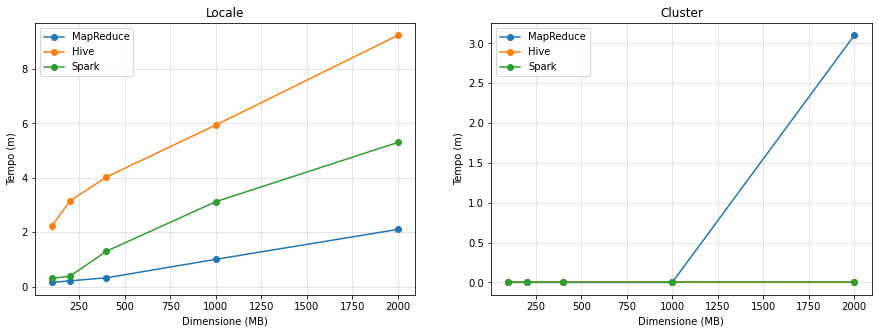

In [8]:
draw_plot(3)